# USD.JPY exchange analysis

In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import pmdarima as pm

pio.renderers.default = "vscode"
fn = "/workspaces/random/usdjpy/USDJPY_1T.csv"

## Load data

In [2]:
df = pd.read_csv(fn, index_col=0, parse_dates=True)
df.head()

ask_open  ask_high  ask_low  ask_close  bid_open  \
TIMESTAMP                                                               
2014-01-01 22:06:00   105.338   105.338  105.334    105.334   105.314   
2014-01-01 22:07:00   105.339   105.354  105.333    105.354   105.321   
2014-01-01 22:08:00   105.354   105.387  105.354    105.365   105.328   
2014-01-01 22:09:00   105.364   105.364  105.364    105.364   105.333   
2014-01-01 22:10:00   105.365   105.391  105.365    105.391   105.333   

                     bid_high  bid_low  bid_close  mid_open  mid_high  \
TIMESTAMP                                                               
2014-01-01 22:06:00   105.317  105.311    105.316  105.3260  105.3260   
2014-01-01 22:07:00   105.342  105.315    105.323  105.3300  105.3480   
2014-01-01 22:08:00   105.336  105.317    105.333  105.3410  105.3605   
2014-01-01 22:09:00   105.333  105.333    105.333  105.3485  105.3485   
2014-01-01 22:10:00   105.345  105.333    105.342  105.3490  105.3665   

                      mid_low  mid_close  
TIMESTAMP                                 
2014-01-01 22:06:00  105.3230   105.3250  
2014-01-01 22:07:00  105.3240   105.3385  
2014-01-01 22:08:00  105.3380   105.3490  
2014-01-01 22:09:00  105.3485   105.3485  
2014-01-01 22:10:00  105.3490   105.3665

In [3]:
df.shape, df.index.min(), df.index.max()

((2759786, 12),
 Timestamp('2014-01-01 22:06:00'),
 Timestamp('2021-05-26 07:34:00'))

For this analysis, we can use the mid_close price as it represents the midpoint between the bid and ask prices at the end of each minute.

## Exploratory Data Analysis / Data Visualization

In [4]:
#keep one line out of 60 - i.e. every hour
df_hourly = df.iloc[::60, :]

In [5]:
fig = go.Figure(data=[go.Candlestick(x=df_hourly.index,
                open=df_hourly['ask_open'],
                high=df_hourly['ask_high'],
                low=df_hourly['ask_low'],
                close=df_hourly['ask_close'])])

# Add titles
fig.update_layout(
    title='USD/JPY Ask exchange rates',
    yaxis_title='USD/JPY',
    xaxis_title="Date"
)

fig.show()

What does a "typical" day look like? Let's plot the mid_close price average and standard deviation  for each day.

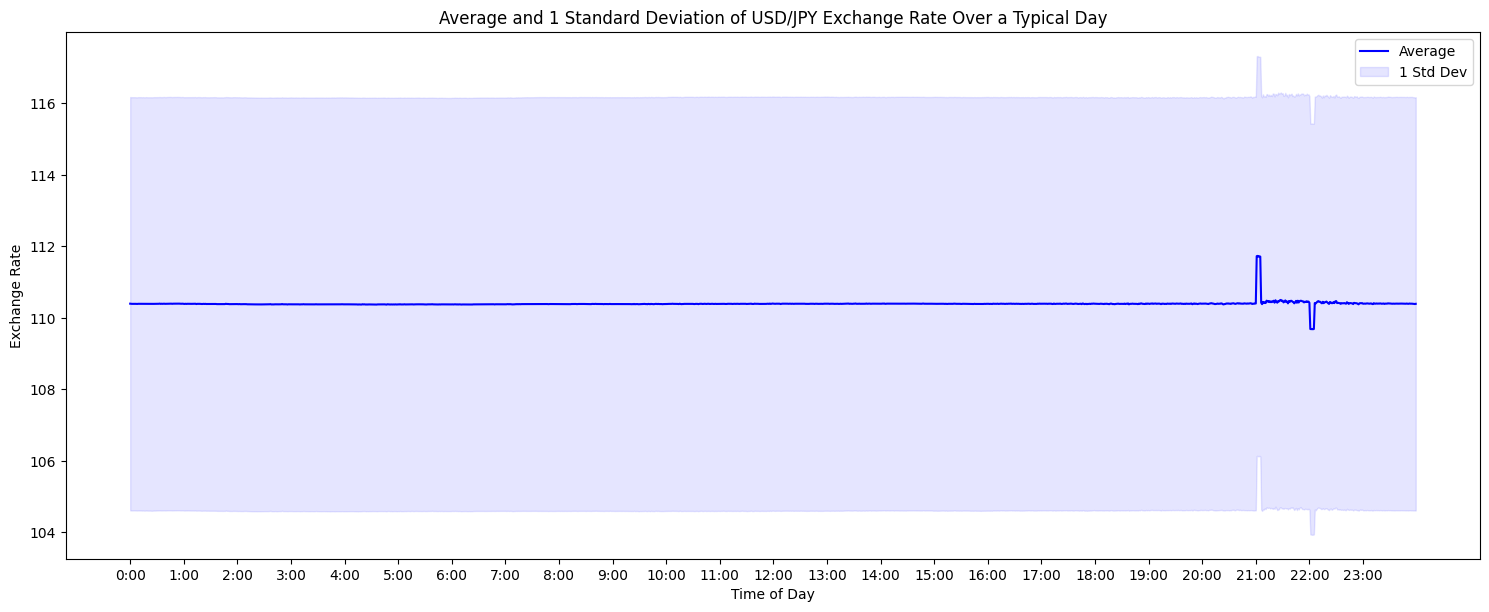

In [6]:
# Plotting
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# Create a new column 'time_of_day' representing the time of day (hour and minute)
df['time_of_day'] = df['hour'].astype(str).str.zfill(2) + ':' + df['minute'].astype(str).str.zfill(2)

# Group by 'time_of_day' and calculate mean and std
df_grouped = df.groupby('time_of_day')['mid_close'].agg(['mean', 'std'])

# Reset index
df_grouped.reset_index(inplace=True)

# Convert 'time_of_day' to datetime.time
df_grouped['time_of_day'] = pd.to_datetime(df_grouped['time_of_day'], format='%H:%M').dt.time

# Convert 'time_of_day' to minutes from midnight
df_grouped['minutes_from_midnight'] = df_grouped['time_of_day'].apply(lambda t: t.hour*60 + t.minute)

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df_grouped['minutes_from_midnight'], df_grouped['mean'], color='blue', label='Average')
ax.fill_between(df_grouped['minutes_from_midnight'], 
                df_grouped['mean'] - df_grouped['std'], 
                df_grouped['mean'] + df_grouped['std'], 
                color='blue', alpha=0.1, label='1 Std Dev')

# Change x-axis to display time of day instead of minutes from midnight
ax.set_xticks(range(0, 24*60, 60))  # every hour
ax.set_xticklabels([f'{h}:00' for h in range(24)])

ax.set_xlabel('Time of Day')
ax.set_ylabel('Exchange Rate')
ax.legend()

fig.tight_layout()
plt.title('Average and 1 Standard Deviation of USD/JPY Exchange Rate Over a Typical Day')
plt.show()


Looks like white noise (as expected), although this graph only does not prove it. There also seems to be some time variability at 21:00 and 22:00.

 Let's plot the autocorrelation function (ACF) to see if there is any correlation between the mid_close price and its past values.

/home/codespace/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning:




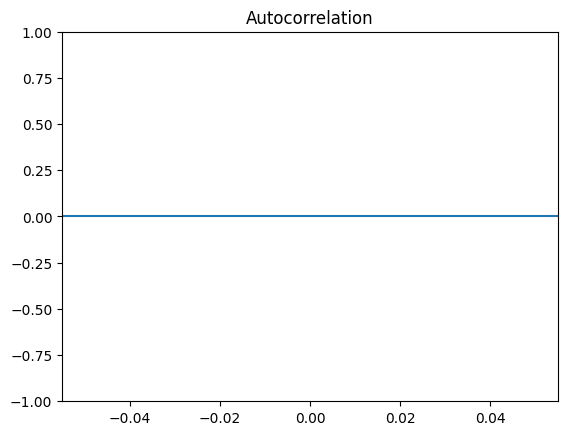

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot the Autocorrelation Function (ACF)
plot_acf(df['mid_close'][::10], lags=50)
plt.show()




Definitely looks like white noise. 

We also try the Ljung-Box test, but it timed out due to the large amount of data.

In [4]:
# # Perform the Ljung-Box test
# from statsmodels.stats.diagnostic import acorr_ljungbox
# ljung_box_results = acorr_ljungbox(df['mid_close'], lags=[10])
# ljung_box_results

What about the change / first-order differential?

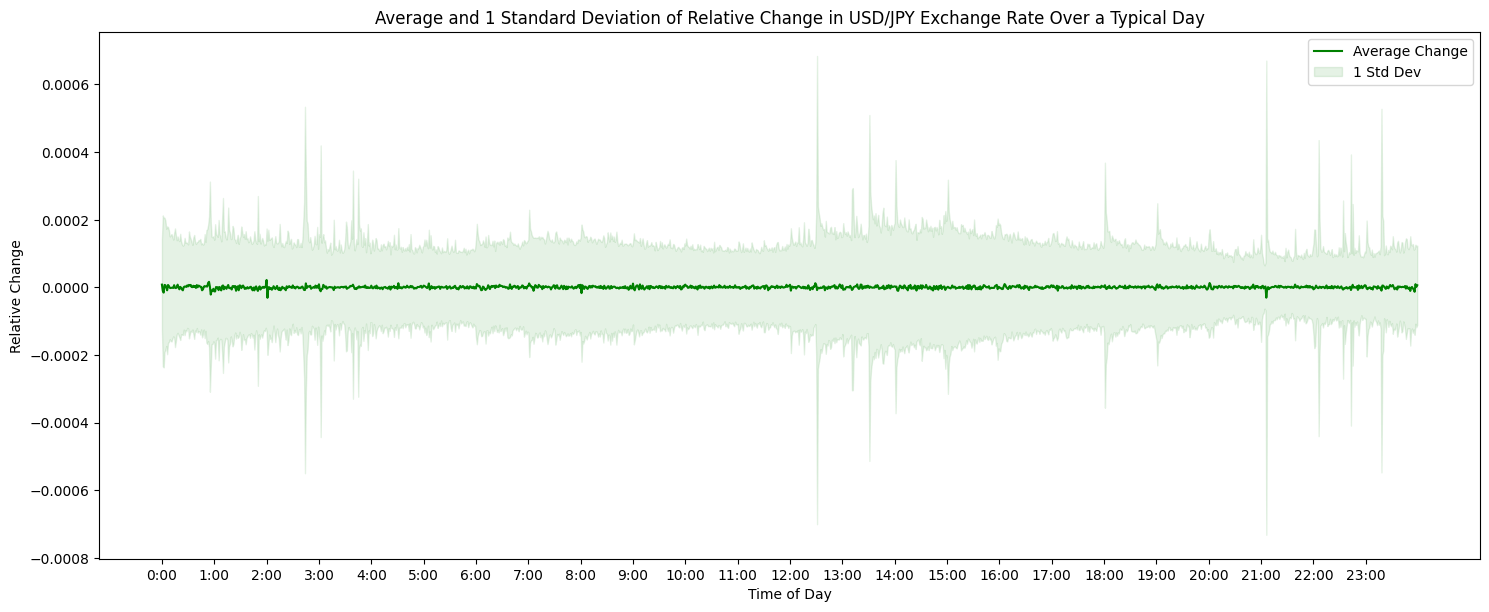

In [9]:
# Compute relative change in 'mid_close'
df['mid_close_change'] = df['mid_close'].pct_change()

# Group by 'time_of_day' and calculate mean and std of the relative change
df_grouped_change = df.groupby('time_of_day')['mid_close_change'].agg(['mean', 'std'])

# Reset index
df_grouped_change.reset_index(inplace=True)

# Convert 'time_of_day' to datetime.time
df_grouped_change['time_of_day'] = pd.to_datetime(df_grouped_change['time_of_day'], format='%H:%M').dt.time

# Convert 'time_of_day' to minutes from midnight
df_grouped_change['minutes_from_midnight'] = df_grouped_change['time_of_day'].apply(lambda t: t.hour*60 + t.minute)

# Plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df_grouped_change['minutes_from_midnight'], df_grouped_change['mean'], color='green', label='Average Change')
ax.fill_between(df_grouped_change['minutes_from_midnight'], 
                df_grouped_change['mean'] - df_grouped_change['std'], 
                df_grouped_change['mean'] + df_grouped_change['std'], 
                color='green', alpha=0.1, label='1 Std Dev')

# Change x-axis to display time of day instead of minutes from midnight
ax.set_xticks(range(0, 24*60, 60))  # every hour
ax.set_xticklabels([f'{h}:00' for h in range(24)])

ax.set_xlabel('Time of Day')
ax.set_ylabel('Relative Change')
ax.legend()

fig.tight_layout()
plt.title('Average and 1 Standard Deviation of Relative Change in USD/JPY Exchange Rate Over a Typical Day')
plt.show()


There are times of increased volatility. Assuming UTC times:
- 12:30 and 21:00 peaks are probably connected to the start and end times of trade in EST and main exchanges. 
- 23:00 and 3:00 peak are probably connected to the starts of respectively the morning and afternoon trading sessions in Japan

## Predictive Modeling

Although white noise is almost impossible to predict, we will try to predict the next value of the mid_close price using the past values. We will use a simple linear regression model.

(Note that there are some some NaN values, around 2014 - for the sake of simplicity, we will just drop them. A rigorous analysis would have to deal with edge effects there.)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

del df
df = pd.read_csv(fn, index_col=0, parse_dates=True).dropna()

# Shift 'mid_close' column to get the mid_close of the following line
df['mid_close_next'] = df['mid_close'].shift(-1)

# Drop the last row (since it has no next row)
df = df[:-1]

# Define input and output variables
X = df.drop(['mid_close_next'], axis=1)
y = df['mid_close_next']

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Calculate metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

rmse, r2

(0.013286276585246313, 0.999960582178882)

Surprinsigly good! But what if we just took the same value as before?

In [11]:
y_pred = X_test['mid_close']
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
rmse, r2

(0.013282852684835528, 0.9999606024923691)

The same. The linear regression degenerated into a zero-order extrapolation. Which fits our hypothesis that the signal looks like white noise, and the optimal estimator would be a zero order estimator. 

For the sake of trying we'll also try auto-ARIMA autoregressive model

In [3]:
# Perform auto-ARIMA on the mid_close column
model = pm.auto_arima(df['mid_close'][::10].dropna(), suppress_warnings=True, trace=False)

# Display the model summary
model.summary()

: 

: 

Even after downsampling, unfortunately the algorithm timed out.

We should also try to make a specific predictor for the 21:00 and 22:00 peaks, since there seems to be some time dependency there and nonrandom components. However due to lack of time we leave this to future analysis.